# Draw phylogenies of Ireland and global M. bovis samples

<div class="alert alert-block alert-info"><b>R Script to draw trees</b> </div>

In [2]:
library("ape")
library("phytools")
library(seqinr)
library(RColorBrewer)
library(dplyr)
library('ggplot2')
library('ggtree')
library(tidytree)
library(ggnewscale)
library('ggtreeExtra')

In [3]:
options(repr.plot.width=20, repr.plot.height=15)

In [4]:
setwd('/storage/btbgenie/combined_results/')
meta <- read.table('/storage/btbgenie/combined_results/metadata.csv',sep=',',
                      header=TRUE,row.names=2)
print (length(rownames(meta)))
meta[is.na(meta)] <- "-"
meta[] <- lapply(meta, as.character)

gltree <- read.tree('/storage/btbgenie/global_results/tree.newick')
meta1 <- read.table('/storage/btbgenie/global_results/metadata.csv',sep=',',
                      header=TRUE,row.names=1)
meta1[] <- lapply(meta1, as.character)
print (length(rownames(meta1)))
mltree <- read.tree('/storage/btbgenie/combined_results/tree.newick')

meta2 <- read.table('/storage/btbgenie/all_ireland_results/metadata.csv',sep=',',
                      header=TRUE,row.names=1)
meta2[] <- lapply(meta2, as.character)
iretree <- read.tree('/storage/btbgenie/all_ireland_results/tree.newick')

[1] 778
[1] 211


In [5]:
length(gltree$tip.label)

[1] 212

In [6]:
plot_tree <- function(tree,samples,type='phylogram',title='',column='SB',cmap="Set1") {
  labels <- samples[tree$tip.label,][[column]]
  #print(labels)
  #print (samples[mltree$tip.label,])
  labels[is.na(labels)] <- "Other"  
  leglabels <- levels(as.factor(labels))
  n<-length(leglabels)
  colors <- brewer.pal(n = n, name = cmap)
  cols<-setNames(colors[1:length(leglabels)],leglabels)
  print (cols)
  l<-length(labels)
  w<- max(dist.nodes(tree))*.8
    
  if (l<70){
      showtip=TRUE
      }
  else {
      showtip=FALSE
  }
  plot(tree,type=type,cex=.5,label.offset=10, edge.width=.6,show.tip.label=showtip)
  title(title,cex.main= 2)
  cex<-(.3/l*100)
  tiplabels(pie=to.matrix(labels, levels(as.factor(labels))),cex=cex,size=2,piecol=cols)
  add.scale.bar(x=100,lwd=2, cex=1)
  legcolors <- cols[leglabels]
  legend("topright", legend=names(cols), pch=22, pt.bg=cols, pt.cex=2.0, cex=1.2, 
         bty="n",ncol=1,x.intersp=.3)
}

In [47]:
gettreedata <- function(tree, meta){
    d<-meta[row.names(meta) %in% tree$tip.label,]
    d$label <- row.names(d)
    y <- full_join(as_tibble(tree), d, by='label')
    y <- as.treedata(y)
    return(y)
}

ggplottree <- function(tree, meta, col1, col2=NULL, col3=NULL, layout="rectangular", cmap='Set1', tiplabel=FALSE, title='') {
    
    colors <- c('#442082', '#3CFDE6', '#F1C26B', '#30F90E', '#C7DD01', '#E48875',
                '#34A20F', '#0B0D04', '#C36ED8', '#0E71E0', '#FD77B0', '#7670EB')
    y <- gettreedata(tree, meta)    
    p <- ggtree(y, layout=layout)
    p1 <- p + scale_color_brewer(palette=cmap) + 
              #scale_fill_manual(values=colors) +
              #geom_text2(aes(subset=!isTip, label=node)) +
              geom_tippoint(mapping=aes( shape=NULL, color=.data[[col1]]),size=3) 
    if (tiplabel==TRUE){  
          p1 <- p1 + geom_tiplab(size=3, color="gray") 
    }
    if (is.null(col2)){        
        p2<-p1
    }
    else {
        df<-meta[tree$tip.label,][col2]
        p2 <- gheatmap(p1, df, offset=70, width=.05,
                  colnames_angle=0, colnames_offset_y = .05) 
 }
         #geom_cladelab(node=10, label="test label") +
         #geom_hilight(mapping=aes(subset = node %in% c(1, 2,4,6), fill = snp50)) + 
    
    if (is.null(col3)){        
        p2<-p2
    }
    else {
        df<-meta[tree$tip.label,][col3]
        p2 <- gheatmap(p2, df, offset=140, width=.05,
                  colnames_angle=0, colnames_offset_y = .05) 
    }  
    
    p2 <- p2 + theme_tree2(legend.text = element_text(size=20), legend.key.size = unit(1, 'cm'), 
                        legend.position="left", plot.title = element_text(size=30)) +
            guides(color = guide_legend(override.aes = list(size=10))) +
            ggtitle(title) 
    
    return(p2)
}

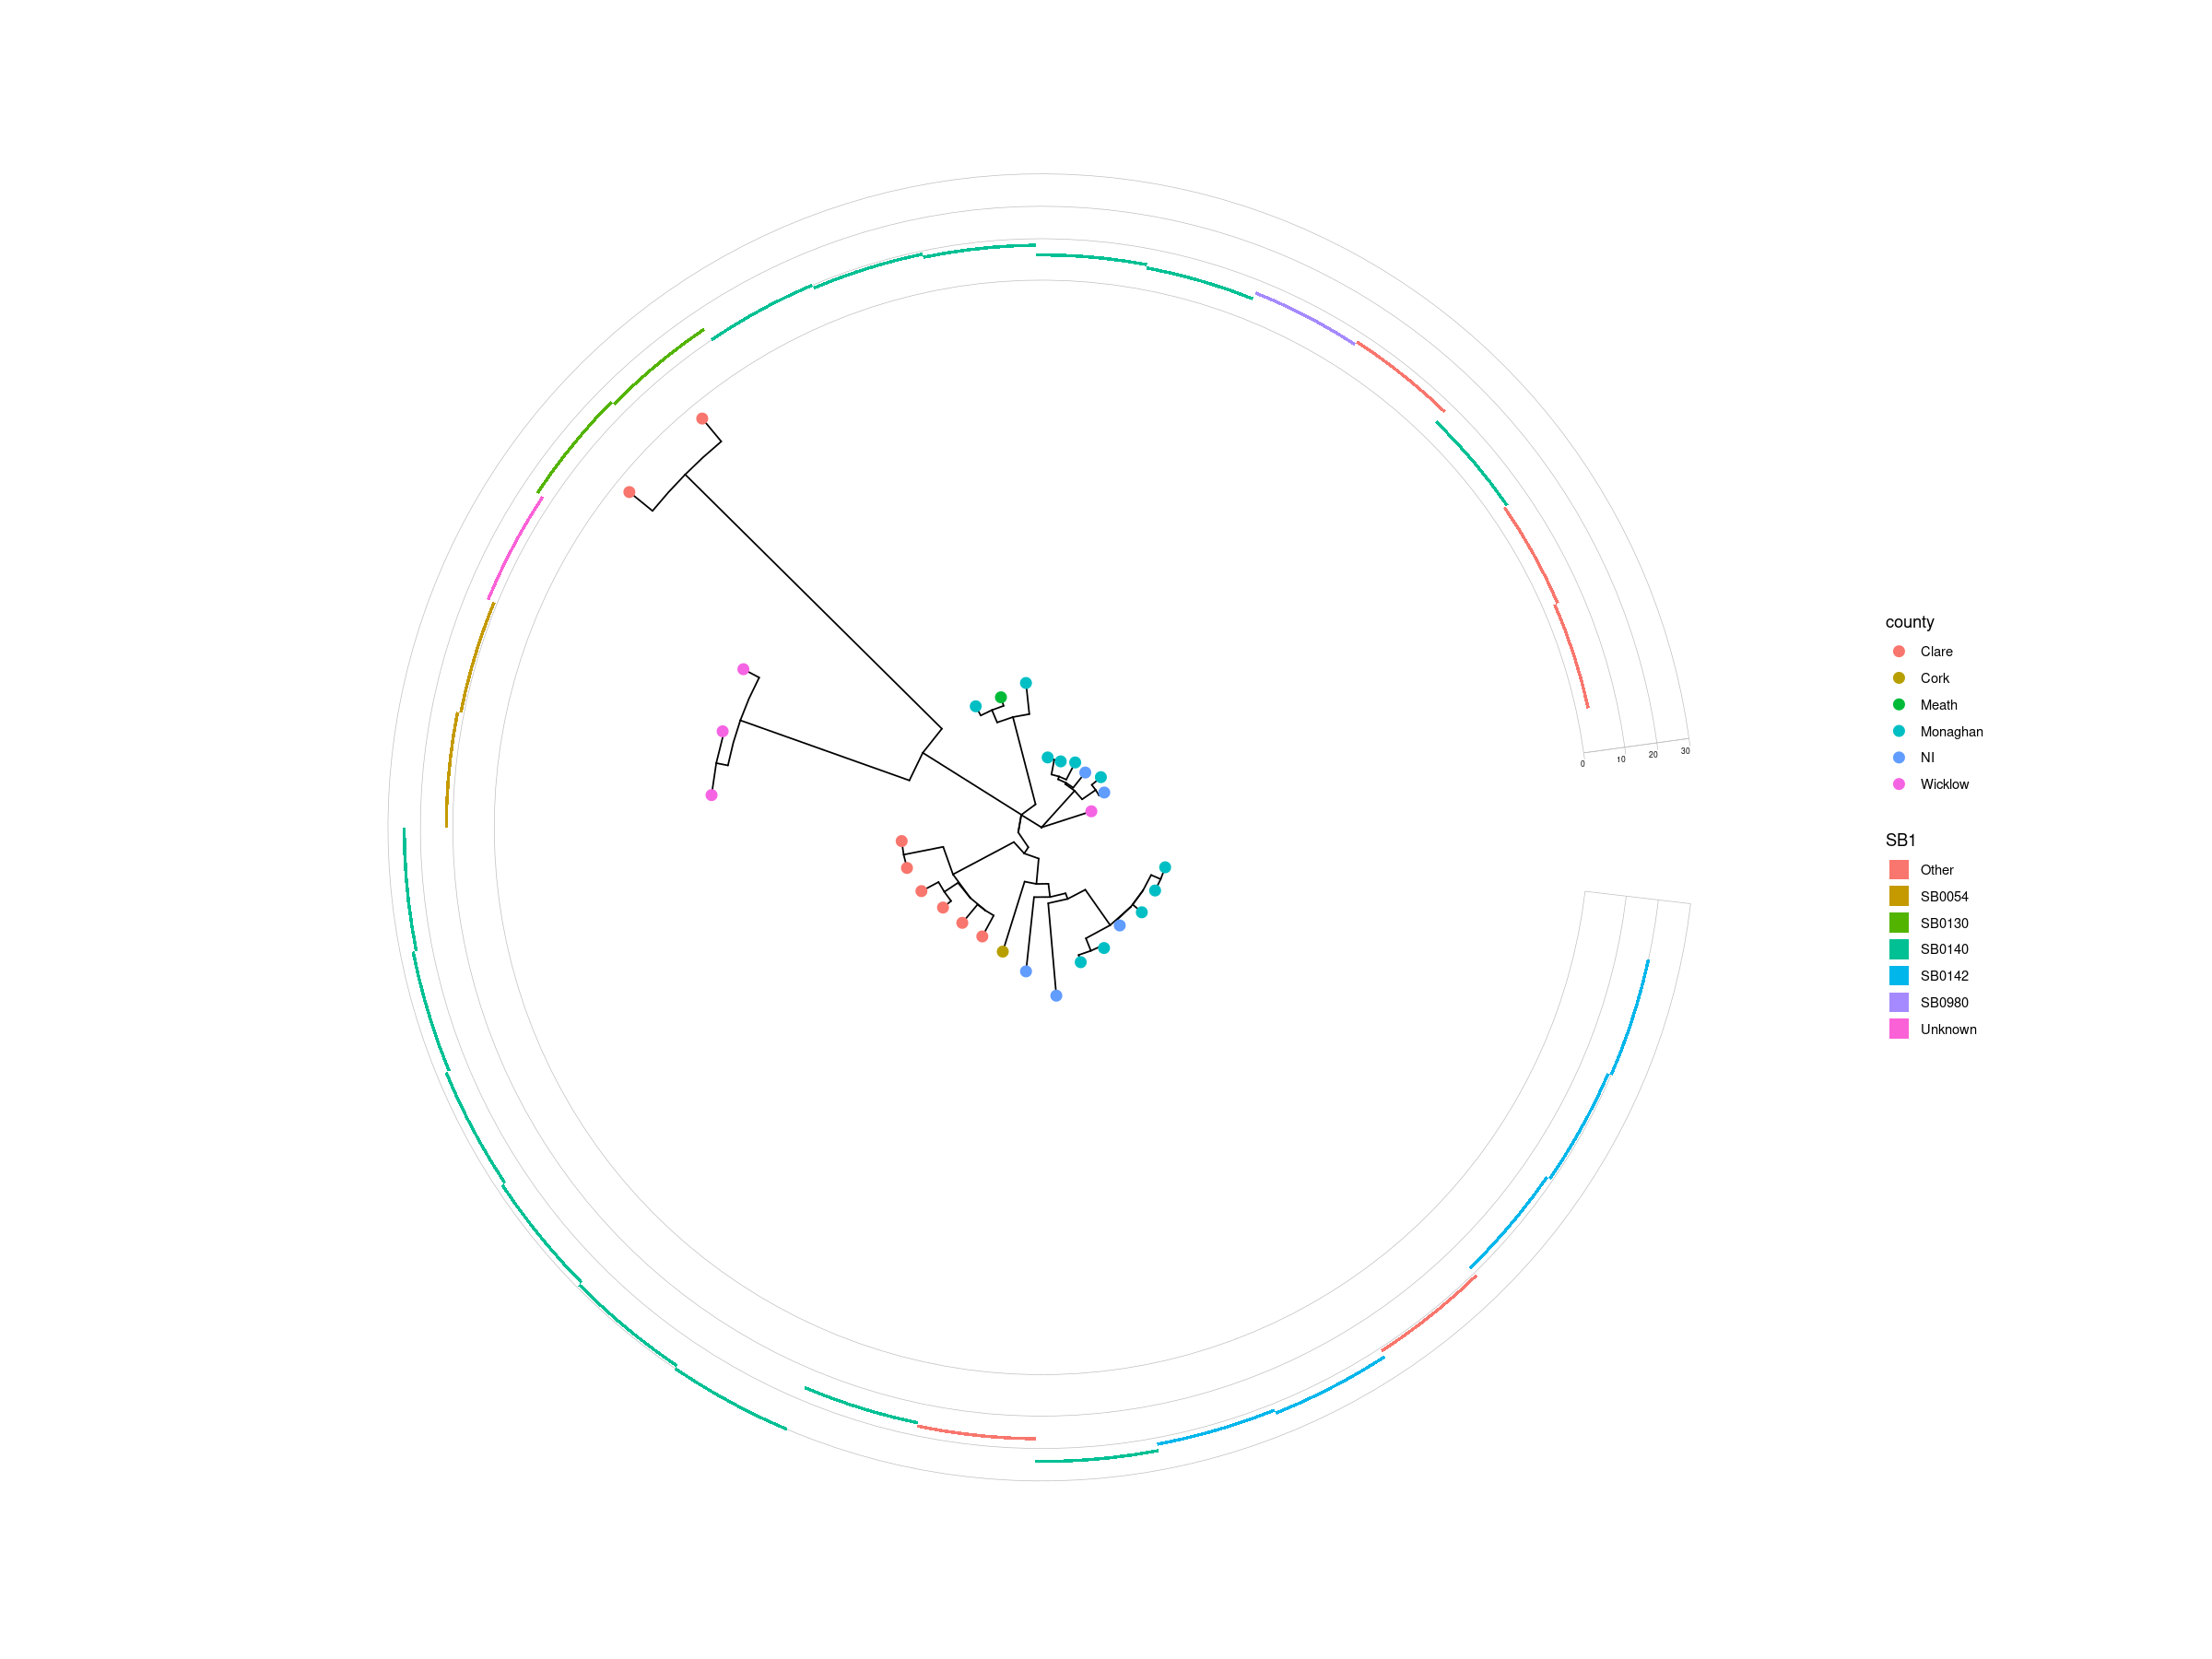

In [8]:
ggtreefruit <- function(tree, meta, layout='c', col1=NULL){
    y <- gettreedata(tree, meta)    
    p <- ggtree(y, layout=layout) +
            geom_tippoint( mapping=aes( shape=NULL, color=.data[[col1]]),size=3) 
    
    p <- p +
         geom_fruit(             
             geom = geom_tile,
             mapping = aes( x=node, 
                         group=RDWicklow,
                         fill=SB1),size=2,
            axis.params=list(
                         axis       = "x",
                         text.size  = 1.8,
                         hjust      = 1,
                         vjust      = 0.5,
                         nbreak     = 3,
                     ),
         grid.params=list())
    
    return(p)
}

randtips<-sample(iretree$tip.label,30)
randtree <- keep.tip(iretree, randtips)
ggtreefruit(randtree, meta2, col1='county')

In [67]:
labelclades <- function(p, labels){    
    for(l in names(labels)){        
        p <- p + geom_cladelab(node=labels[[l]], label=l, angle=0, offset=30, fontsize=9)
    }
    return(p)
}

highlightclades <- function(p){
    p <- p +
     geom_hilight(node=20, fill="lightblue", alpha=.2)
    return(p)
}

Warning message:
“Removed 2 rows containing missing values (geom_point_g_gtree).”


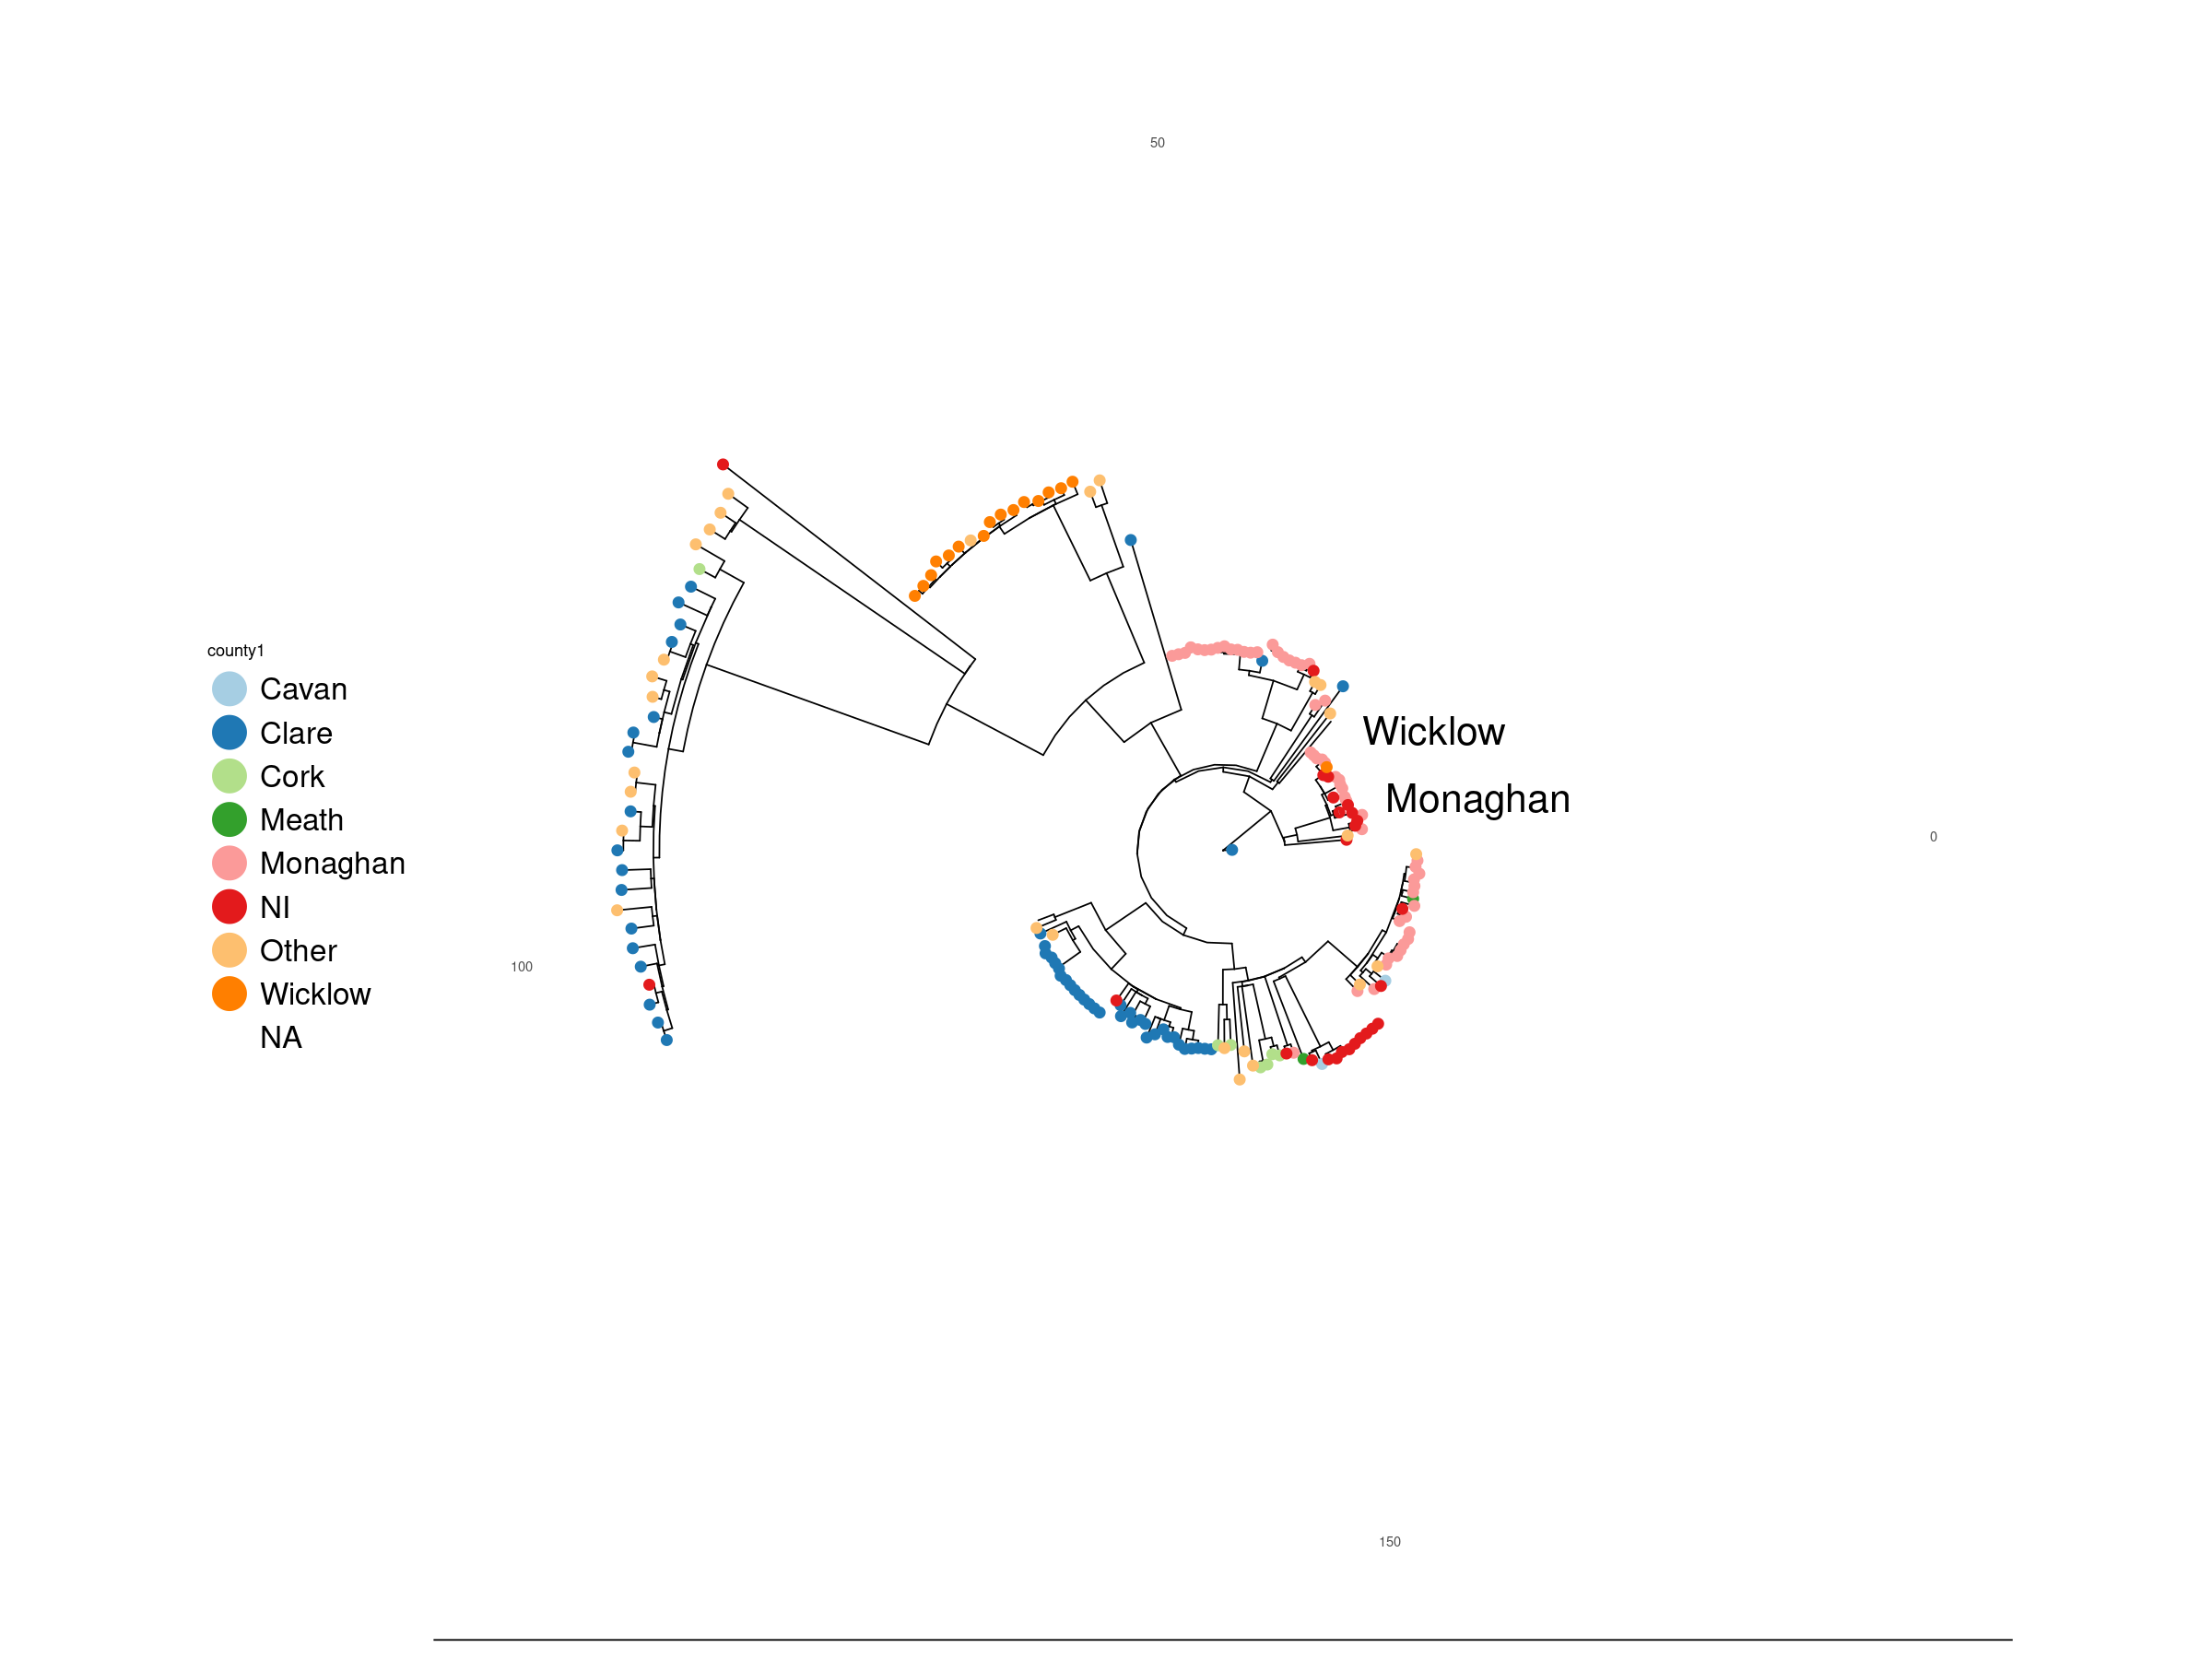

In [74]:
p<-ggplottree(randtree, meta2, layout='c', 'county1', cmap='Paired')
labels <- list(Wicklow=10,Monaghan=20)
p<-labelclades(p, labels)
highlightclades(p)

## global

Warning message:
“Removed 1 rows containing missing values (geom_point_g_gtree).”


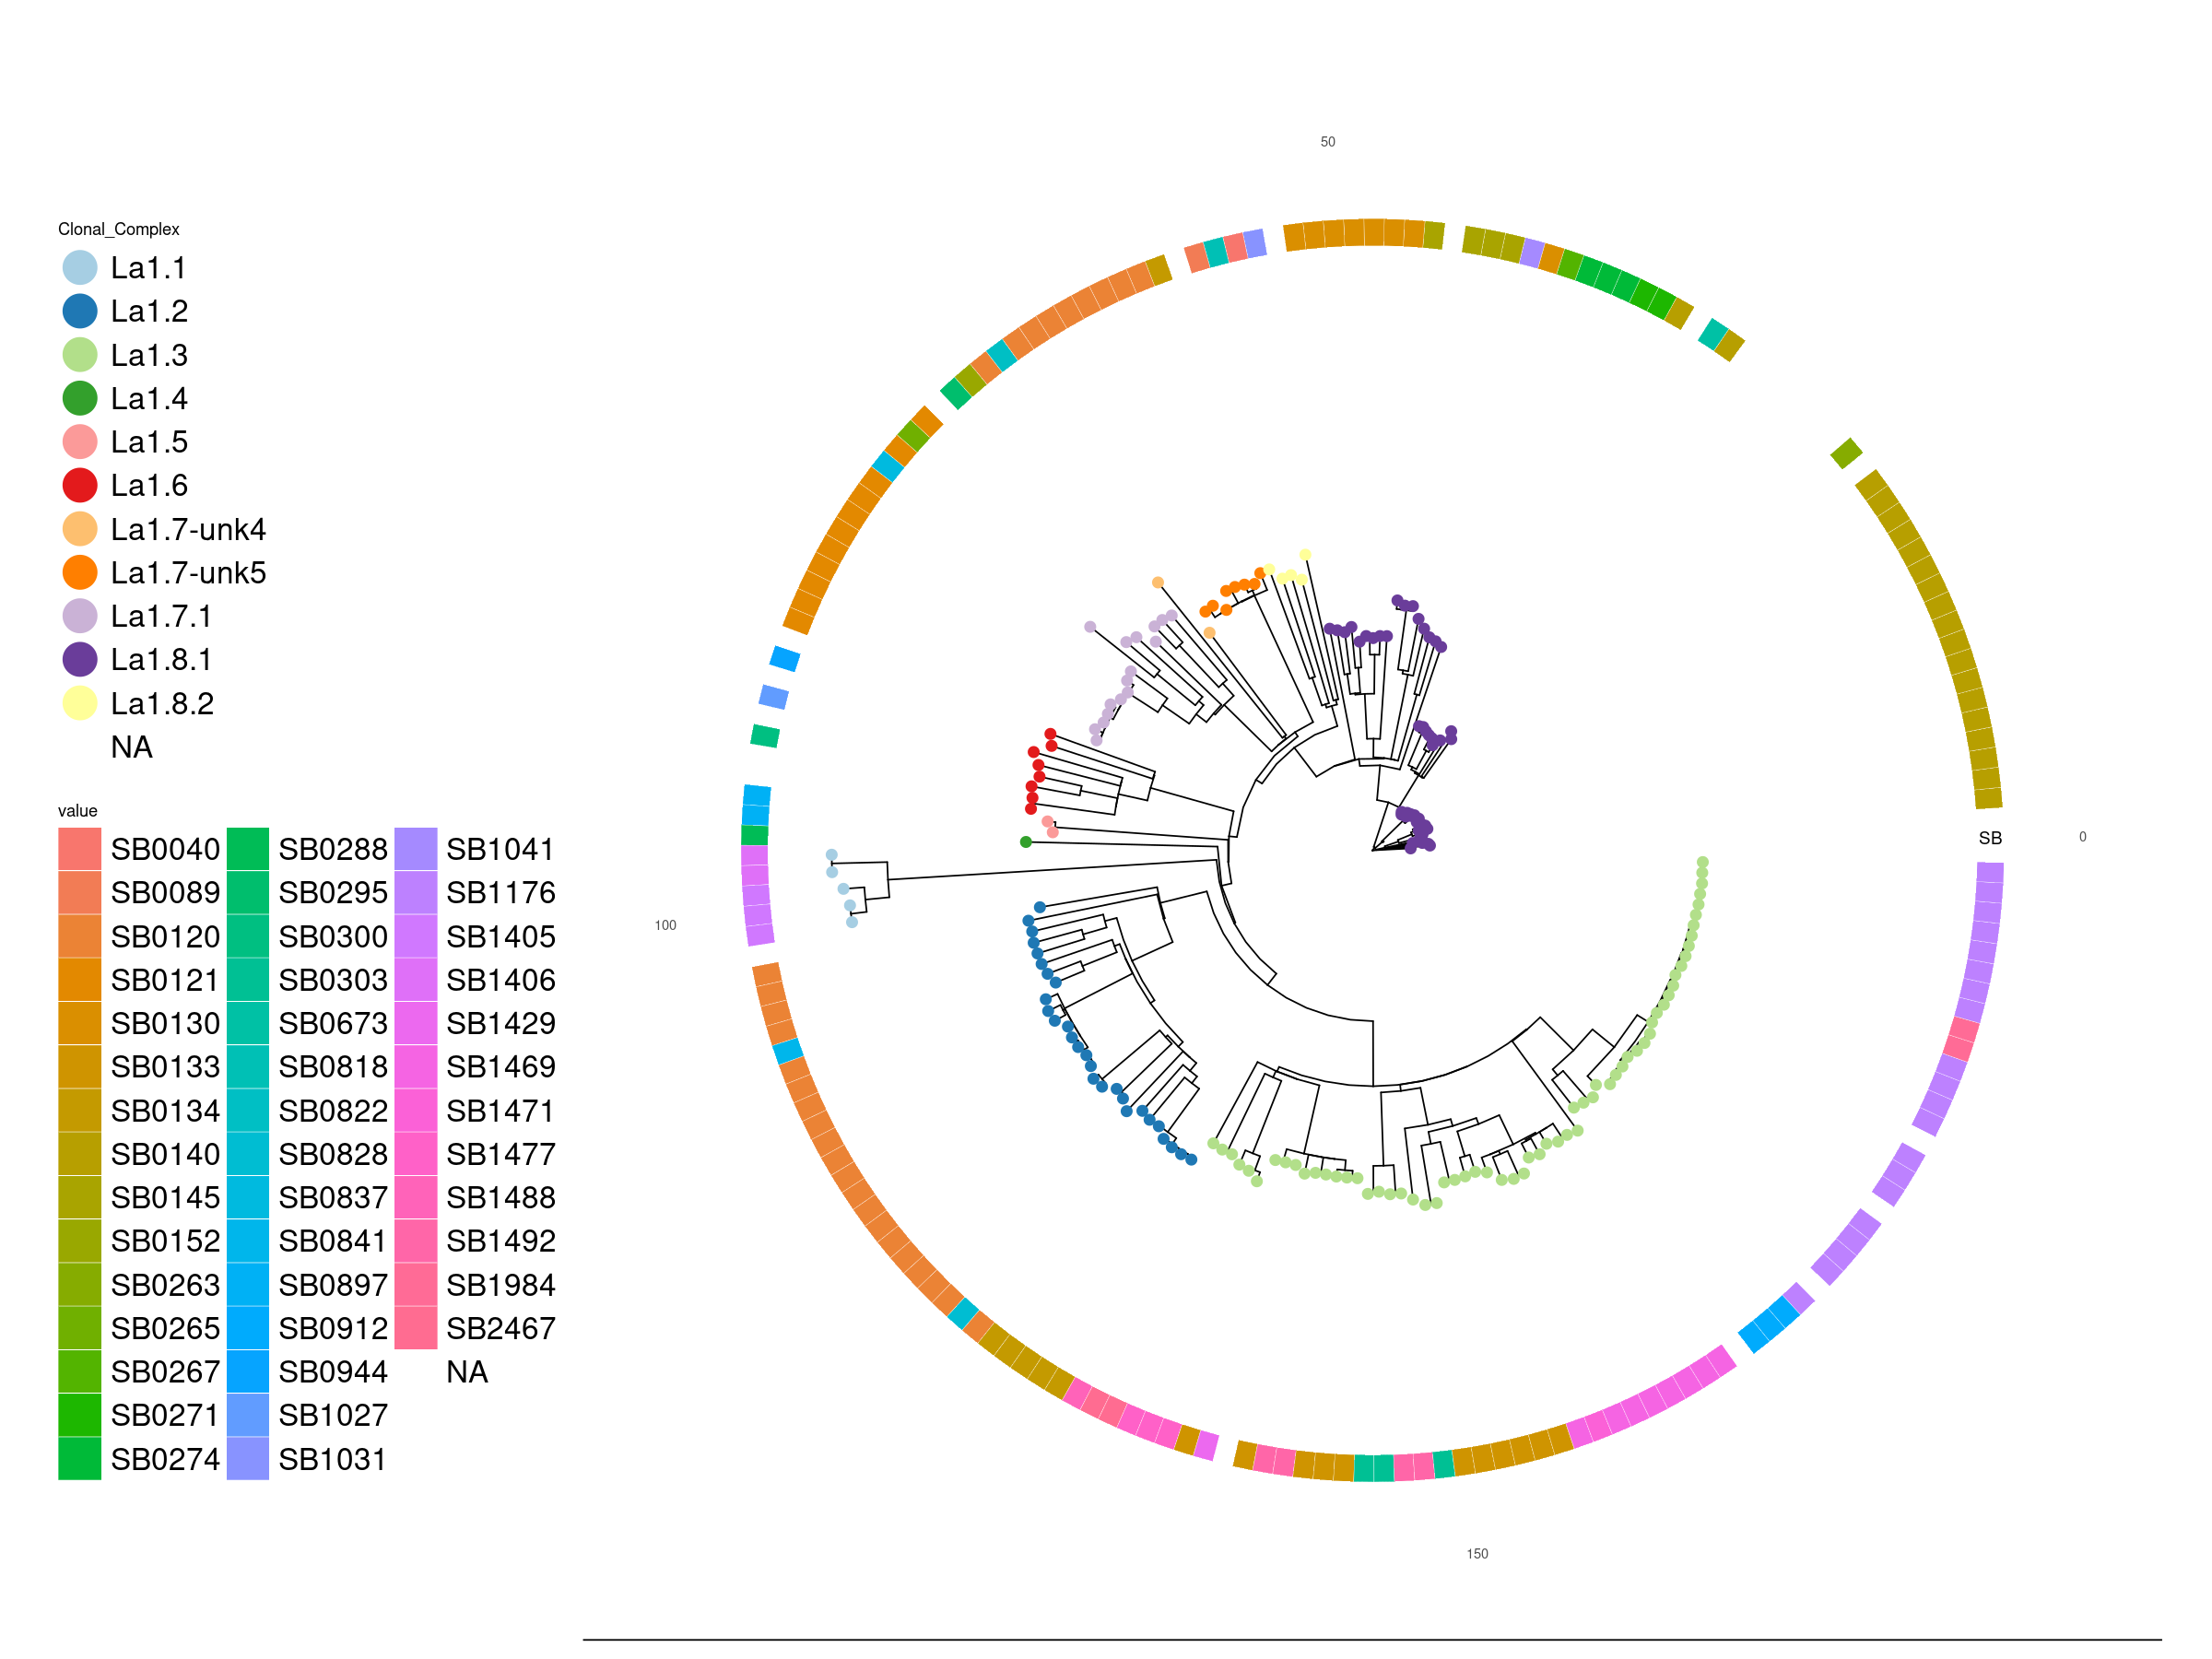

In [63]:
tips<-row.names(meta[(meta$cc %in% c('La2','La3')),])
stree <- drop.tip(gltree, tips)
ggplottree(stree, meta1, layout='c', 'Clonal_Complex','SB', cmap='Paired')

In [633]:
colnames(meta1)

[1] "filename1"                             
 [2] "filename2"                             
 [3] "name1"                                 
 [4] "name2"                                 
 [5] "read_length"                           
 [6] "bam_file"                              
 [7] "mapped"                                
 [8] "reads"                                 
 [9] "perc_mapped"                           
[10] "Accession_Number"                      
[11] "Clonal_Complex"                        
[12] "Country"                               
[13] "Gnumber"                               
[14] "Host"                                  
[15] "Map"                                   
[16] "SIB_Number"                            
[17] "Sample.included.in.Loiseau.et.al..2020"
[18] "Unnamed..0"                            
[19] "SB"                                    
[20] "code"                                  
[21] "RD1mic"                                
[22] "RD5"                                   
[23] "RDWicklow"

## ancestral state reconstruction

In [ ]:
phy <- root(gltree, outgroup='ref')
phy$edge.length[phy$edge.length==0]<-max(nodeHeights(phy))*1e-6
data <- meta1[phy$tip.label, ]
rd <- data$RDWicklow
MLrec <- ace(rd, phy, type="discrete", method="ML")
rd

## combined, global + Ireland

Warning message:
“Removed 2 rows containing missing values (geom_point_g_gtree).”


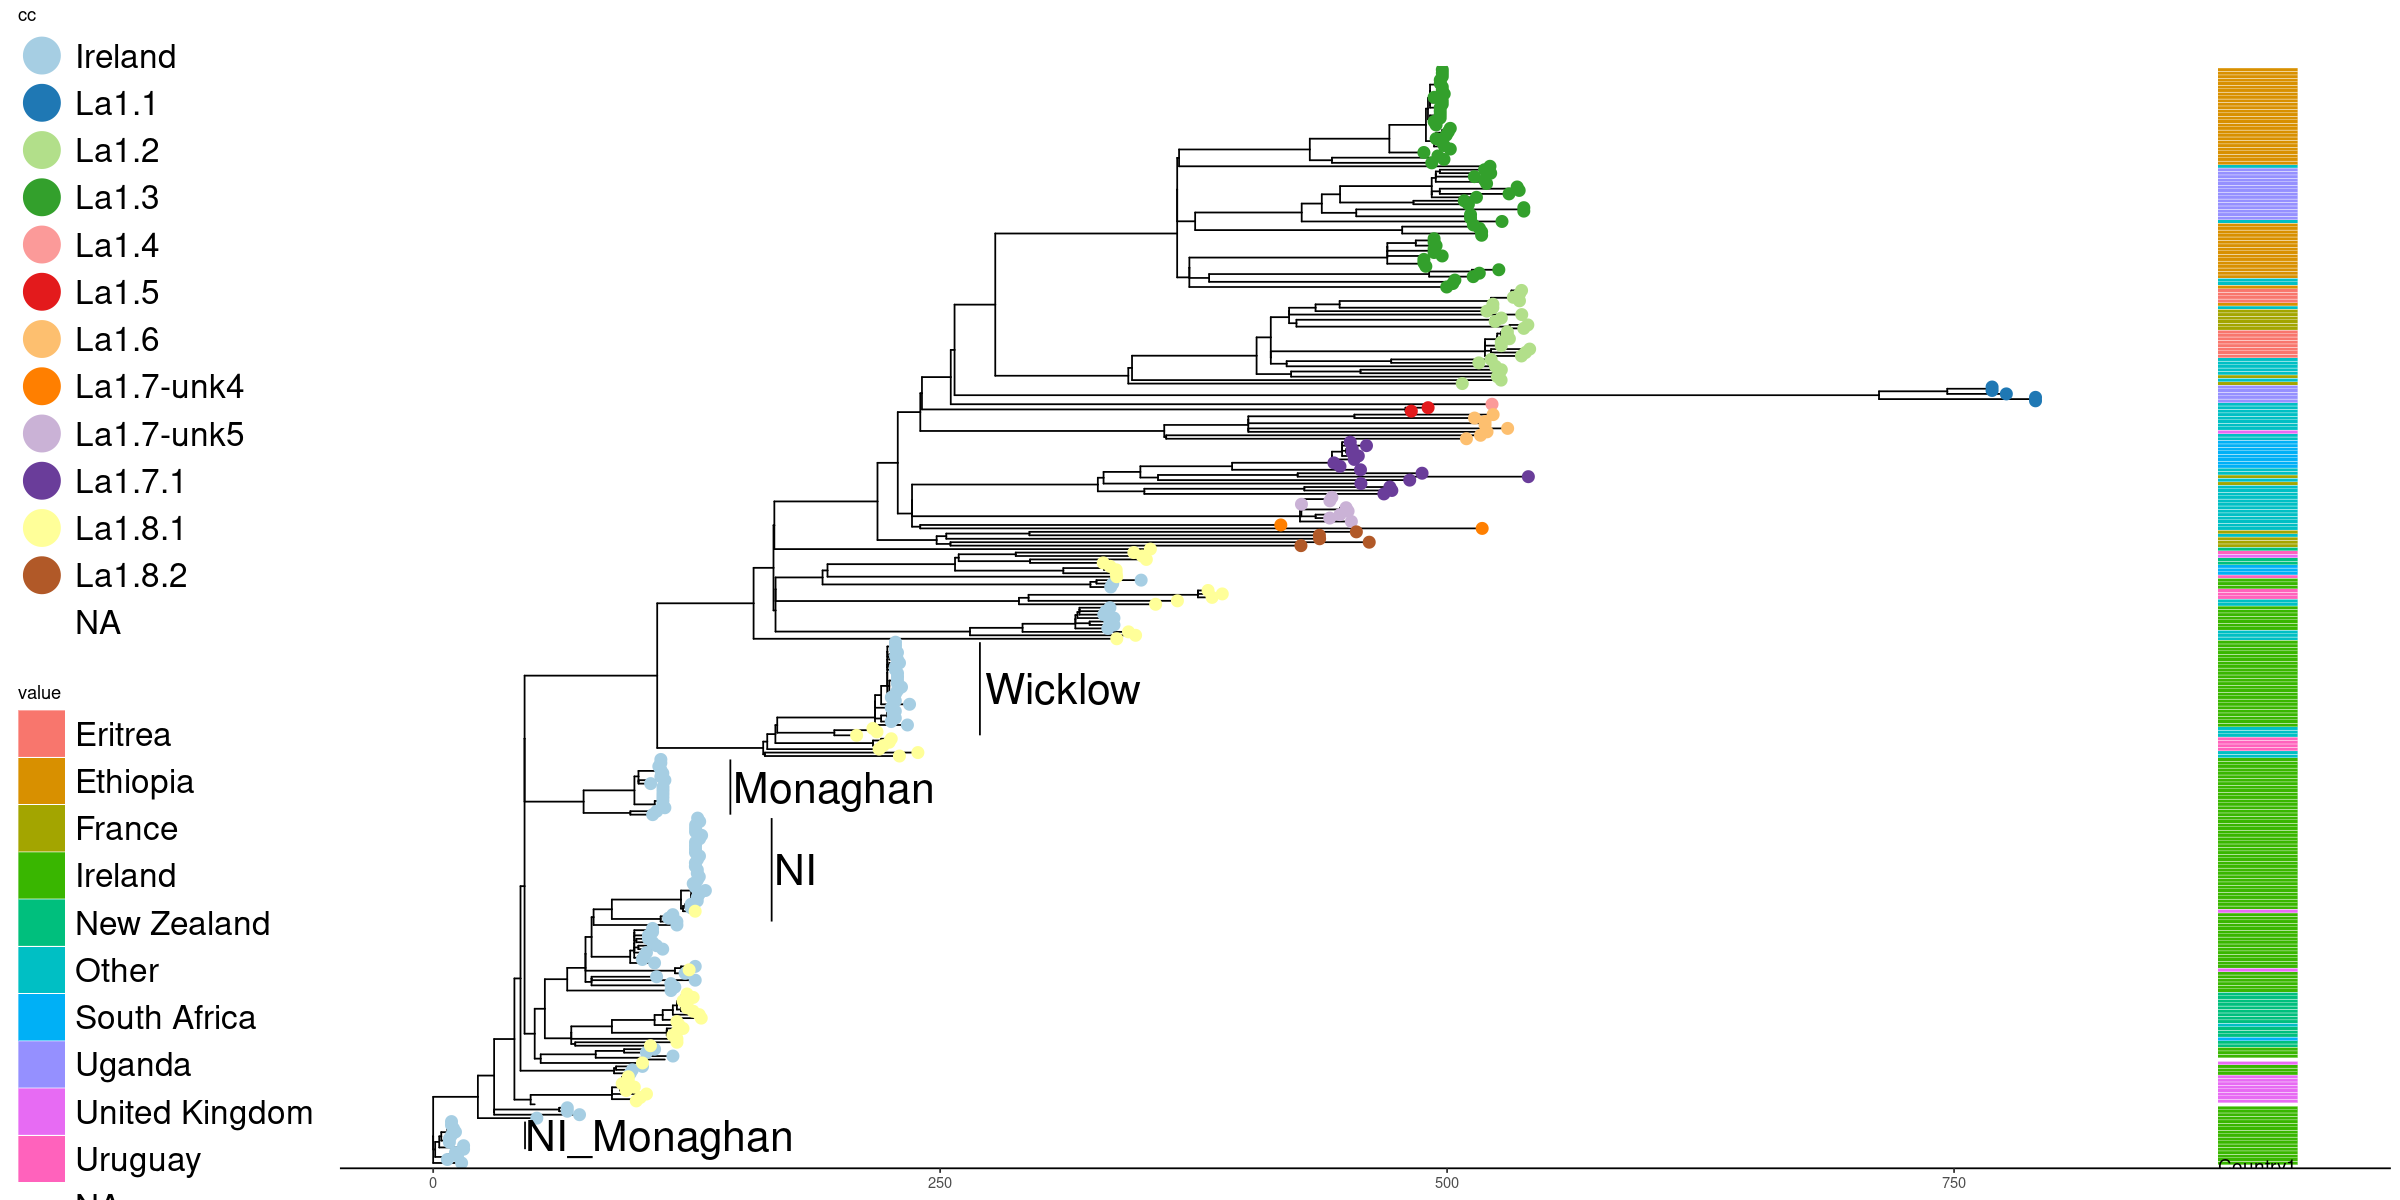

In [79]:
options(repr.plot.width=20, repr.plot.height=10)
tips<-row.names(meta[(meta$cc %in% c('La2','La3')),])
stree <- drop.tip(mltree, tips)
p<-ggplottree(stree, meta, layout='rect', 'cc','Country1', cmap='Paired', title='')
labels <- list(Wicklow=360,Monaghan=339,NI_Monaghan=321,NI=561)
labelclades(p, labels)

"daylight" method was used as default layout for unrooted tree.

Average angle change [1] 0.366880237060781

Average angle change [2] 0.293394455793662

Average angle change [3] 0.163353790651126

Average angle change [4] 0.161704854579015

Average angle change [5] 0.0880851053349312

Warning message:
“Removed 2 rows containing missing values (geom_point_g_gtree).”


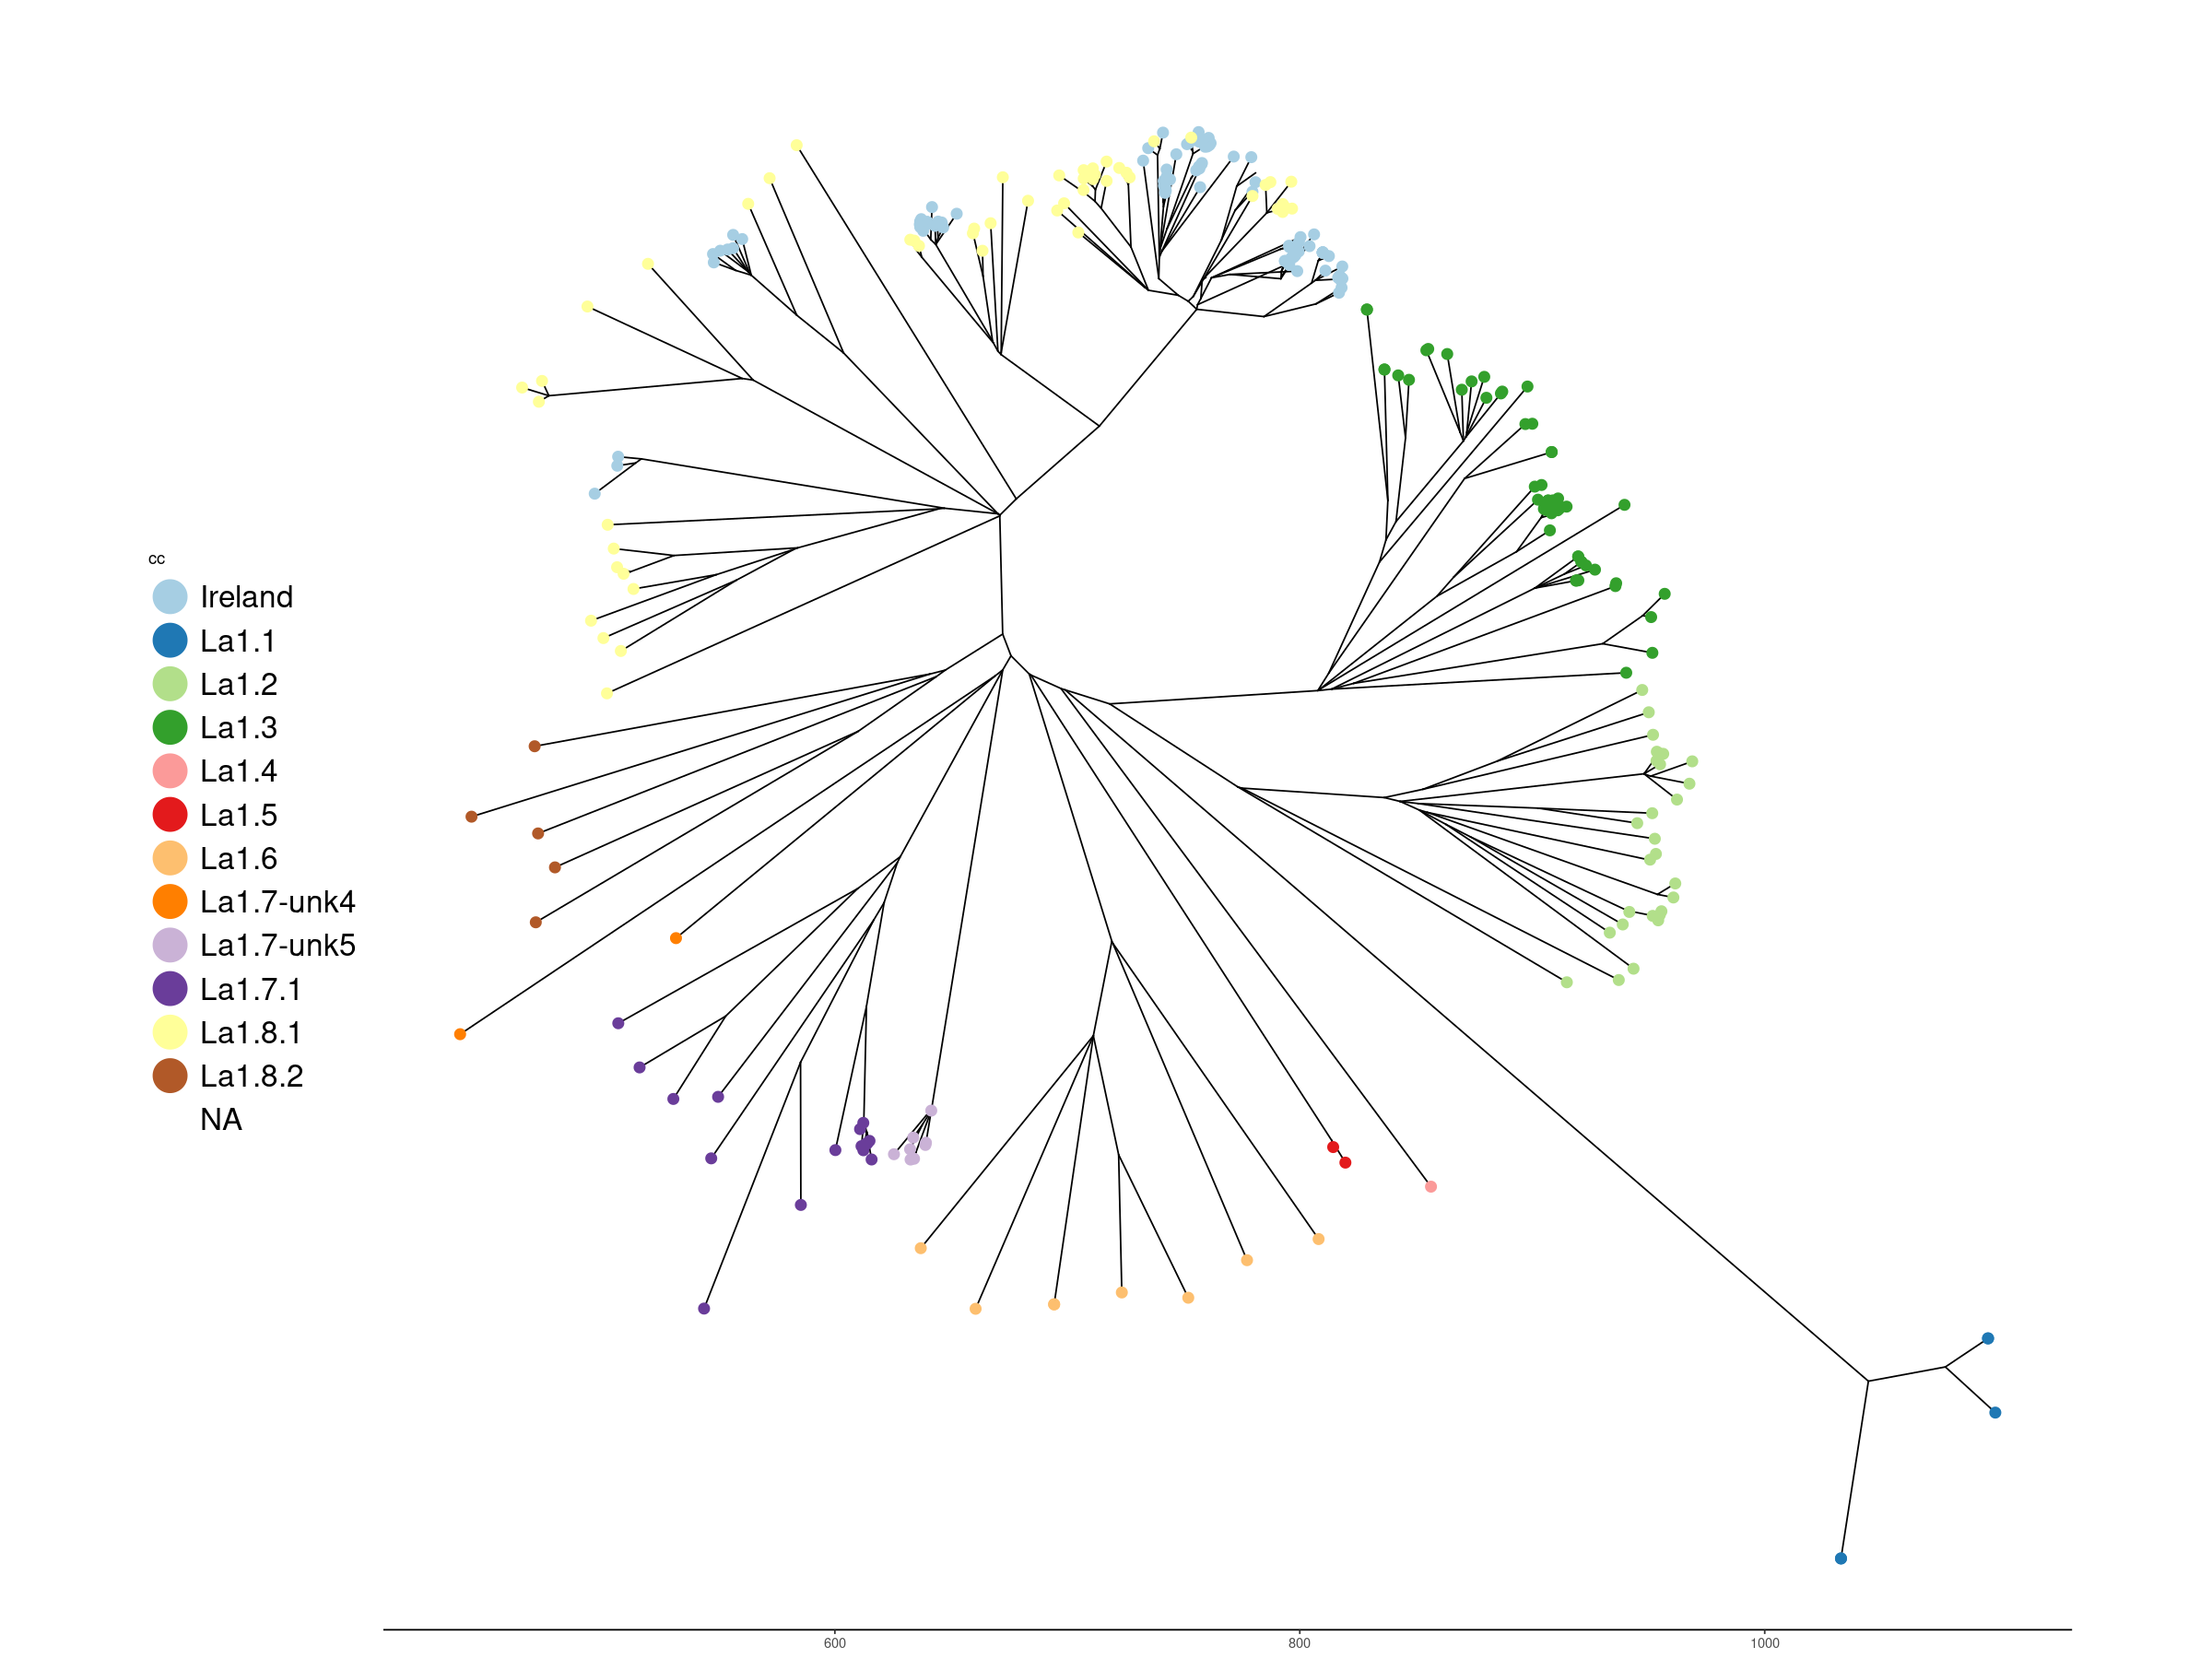

In [73]:
ggplottree(stree, meta, layout='unrooted', 'cc', cmap='Paired')

In [ ]:
#plot_tree(mltree,meta,column='SB1',cmap='Set1')
p<-ggplottree(mltree, meta, 'county1', 'snp100')
labelclades(p)

In [ ]:
#clustered samples only
snp100cl <- c(4, 5, 9, -1, 8, 18, 15, 6, 7, 33, 37, 32, 28, 20, 42, 29, 17, 22, 13)
snp50cl <- c(19, 7, 21, 34, 25, 46, 56, 49, 9, 65, 28, 33, 43, 47, 12, 24, 14, 40)
snp12cl <- c(36, 72, 35, 46, 21, 38, 37, 52, 39, 16, 51, 82, 74, 22, 19, 73, 60, 8, 48)
tips<-row.names(meta[(meta$snp100 %in% snp100cl),])
itree <- keep.tip(mltree, tips)
ggplottree(subtree, meta, 'county1',  'SB1', layout='rect',cmap='Paired',title='global samples, snp50 clusters')

In [555]:
ggplottree(itree, meta, 'Country', cmap='Spectral', title='global samples, snp100 clusters',layout='unrooted')

"daylight" method was used as default layout for unrooted tree.



## Ireland

Warning message:
“Removed 4 rows containing missing values (geom_point_g_gtree).”


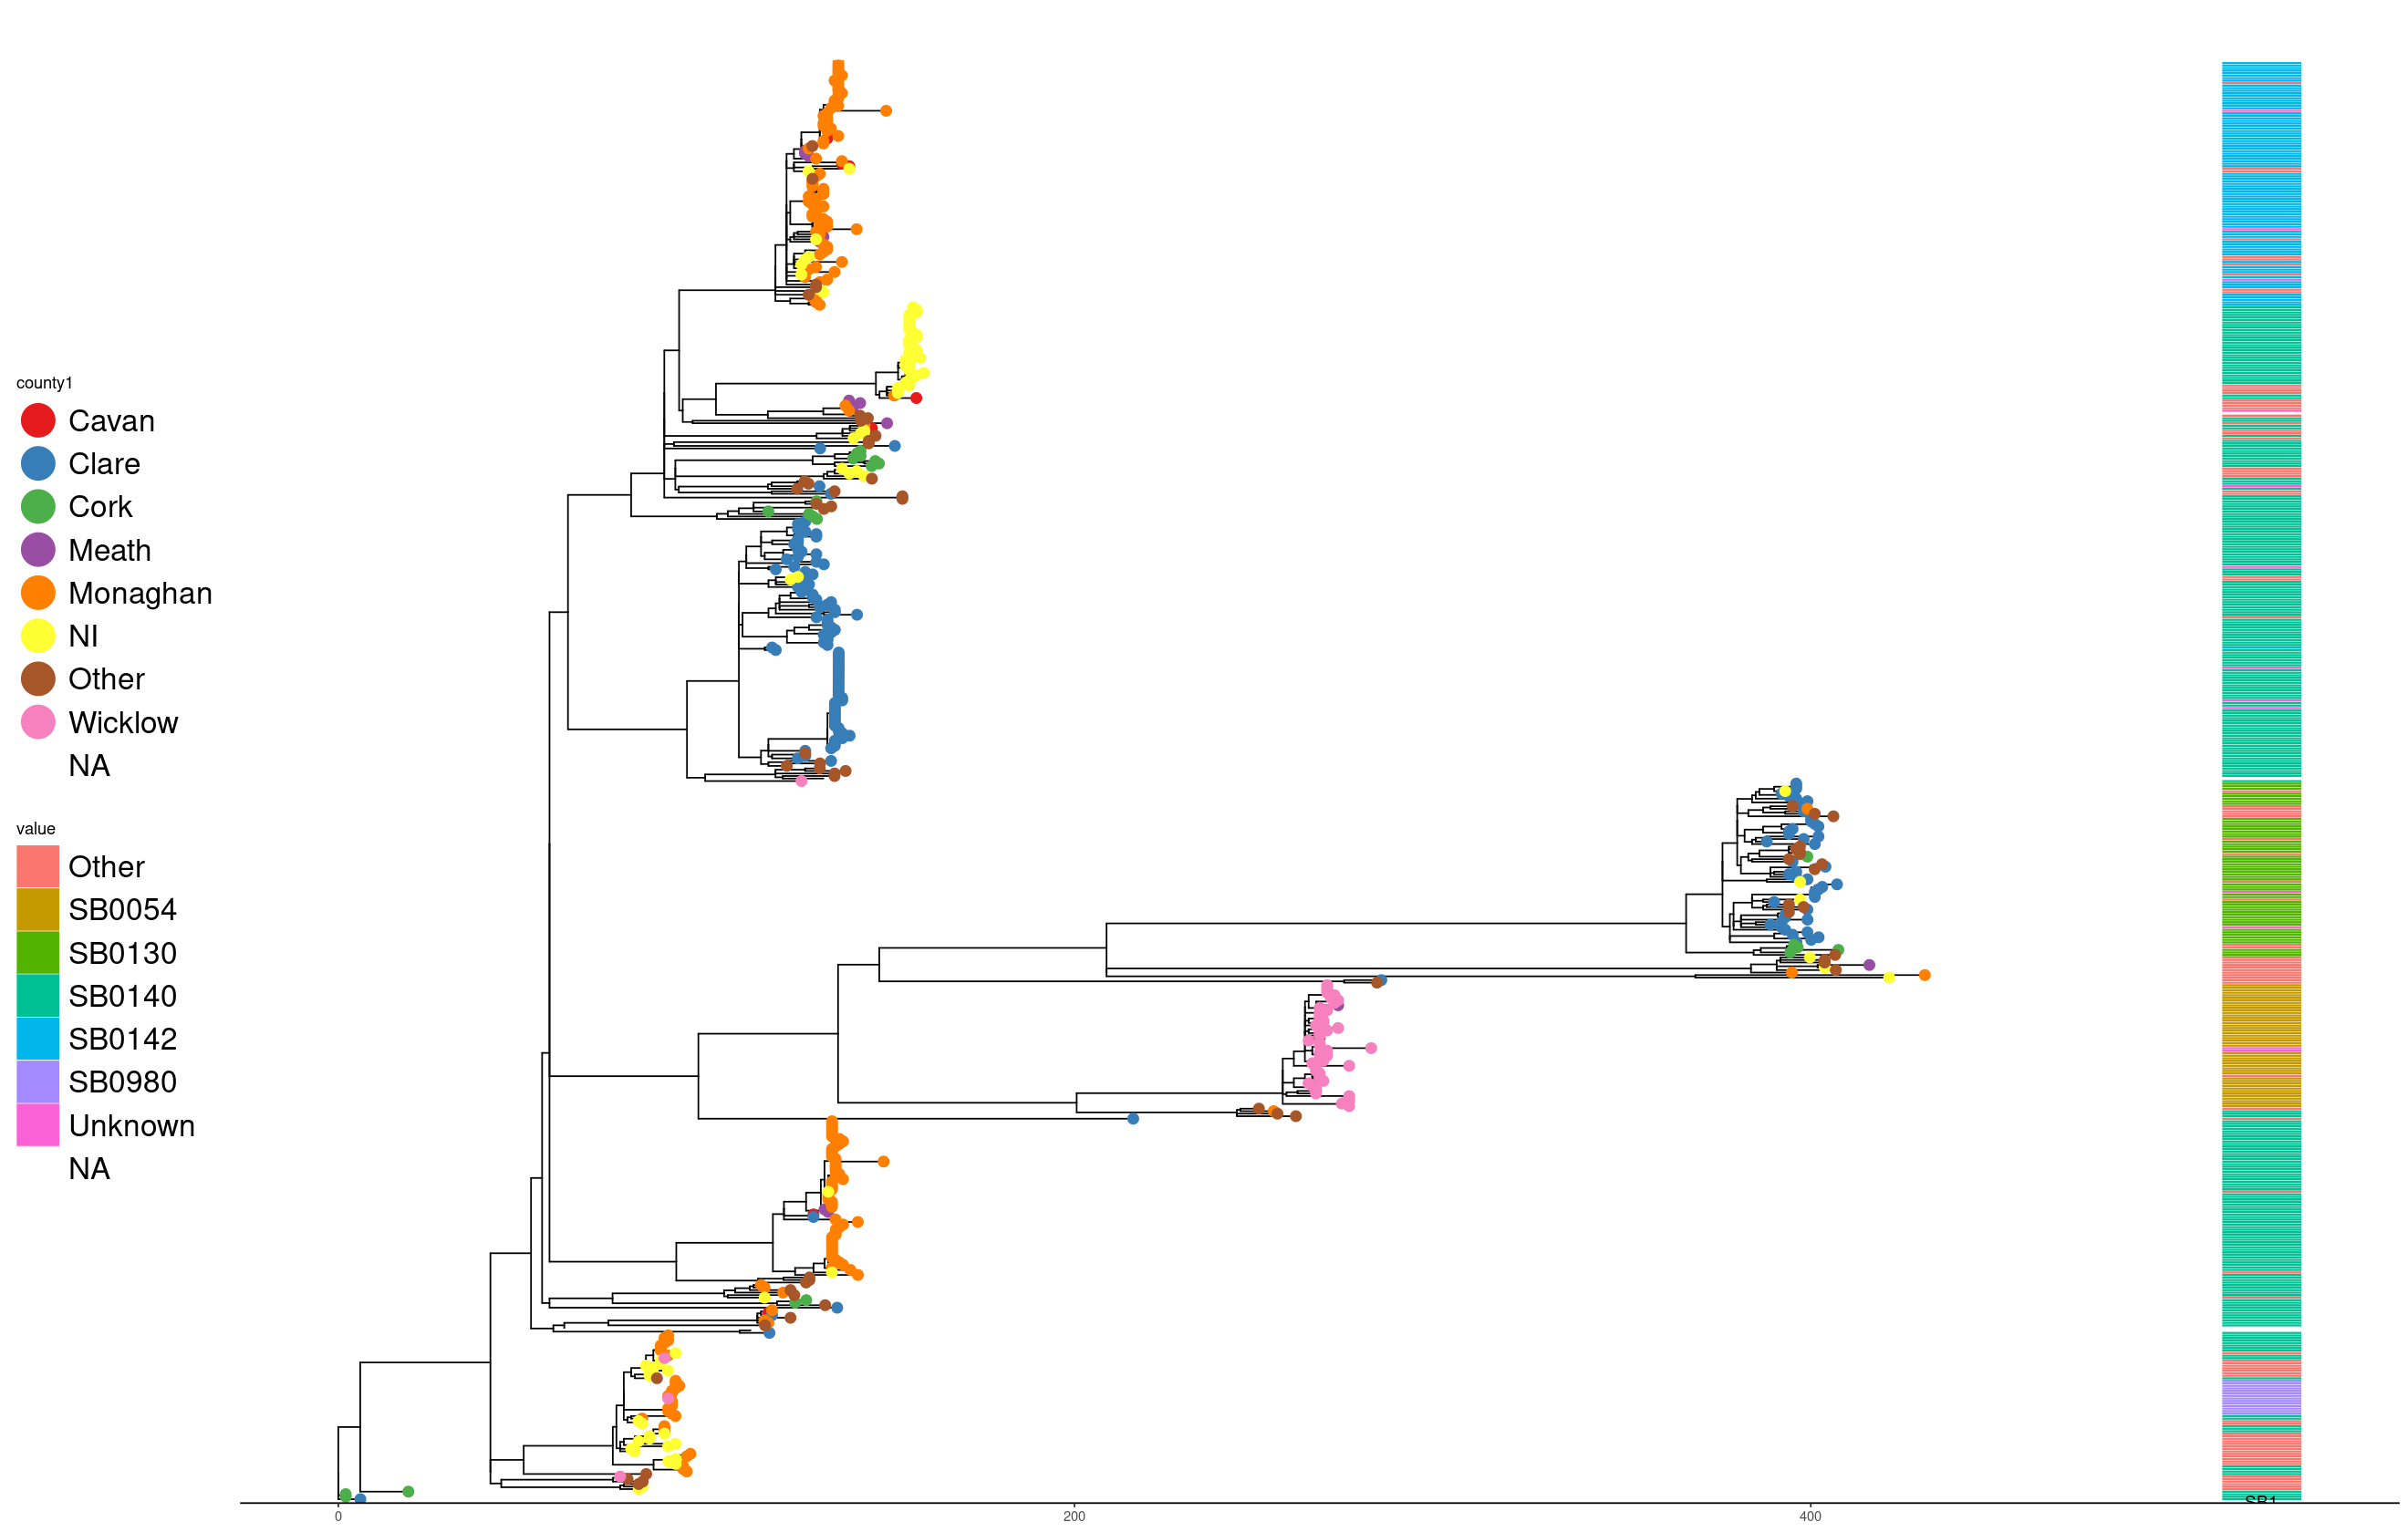

In [86]:
options(repr.plot.width=22, repr.plot.height=14)
randtips<-sample(iretree$tip.label,190)
randtree <- keep.tip(iretree, randtips)
ggplottree(iretree,meta2,'county1','SB1',layout='rect',title='')

"daylight" method was used as default layout for unrooted tree.

Average angle change [1] 0.296240952726745

Average angle change [2] 0.140797082485362

Average angle change [3] 0.177642982459261

Average angle change [4] 0.0675991542708223

Average angle change [5] 0.033682018375616

Warning message:
“Removed 4 rows containing missing values (geom_point_g_gtree).”


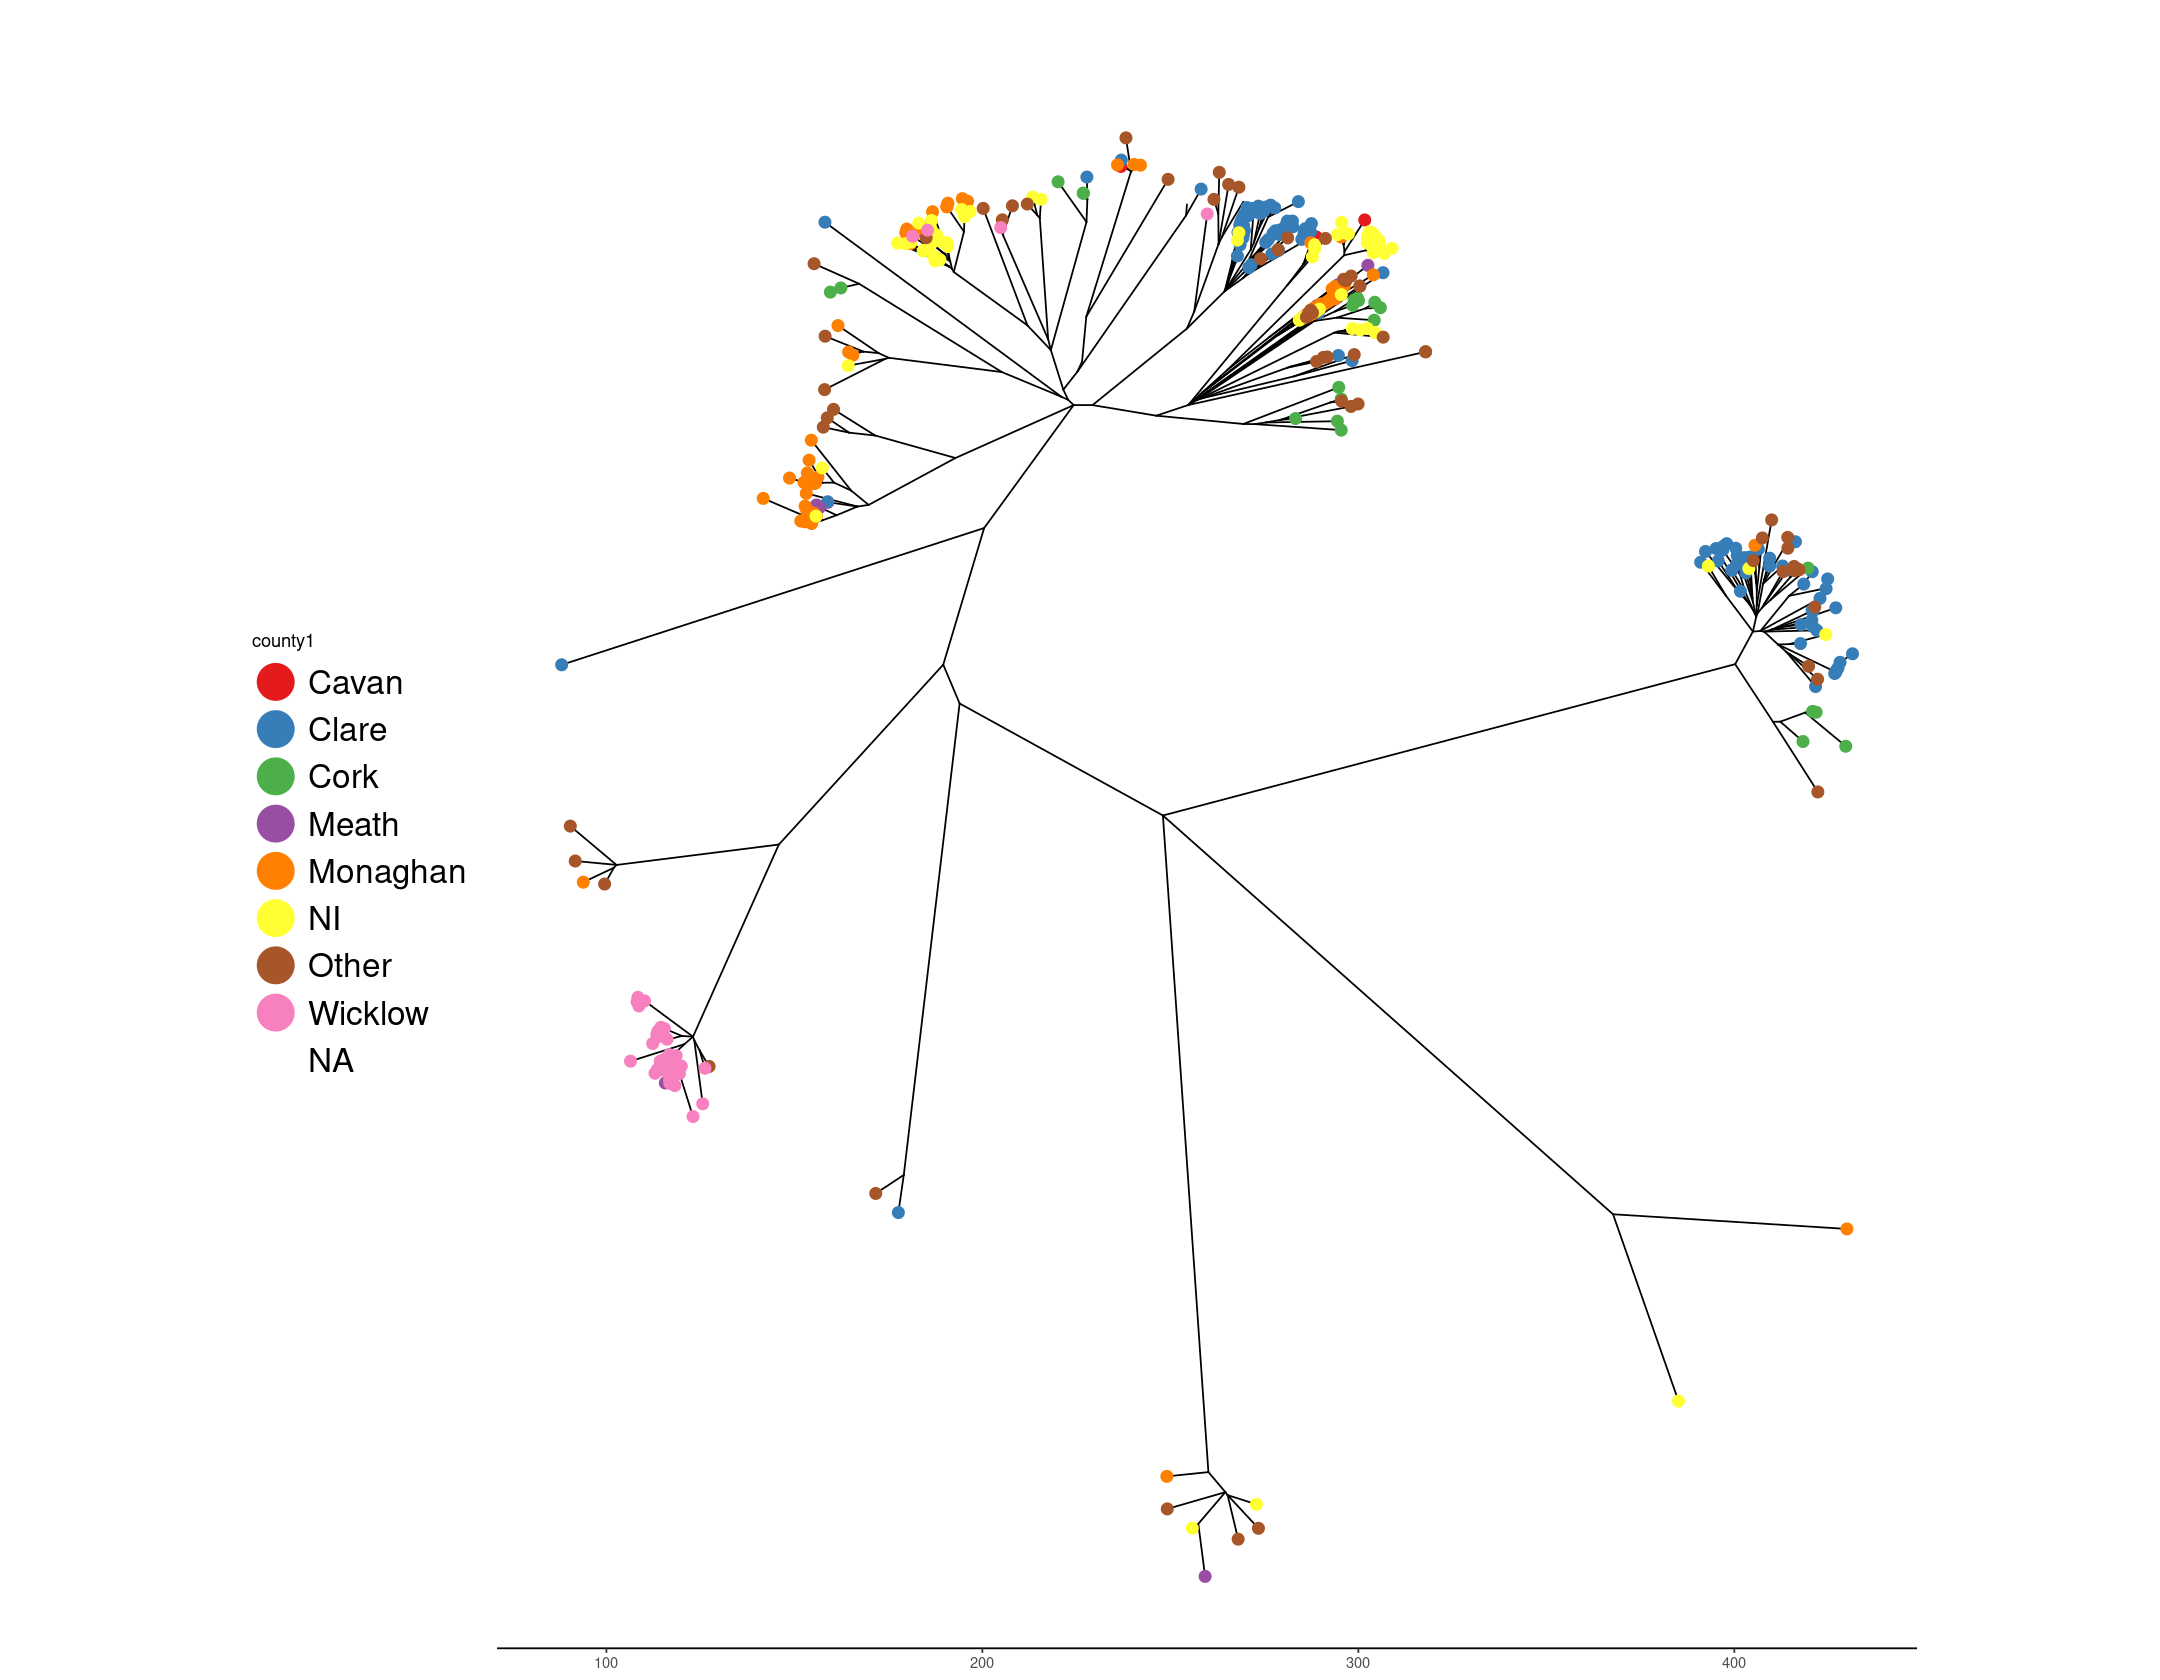

In [83]:
ggplottree(iretree,meta2,'county1',layout='unrooted')